In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
file_path = Path("../Data/Cleaned/psych_assessment_cleaned.csv")
df = pd.read_csv(file_path)

df.shape

(9504, 11)

In [3]:
X = df.drop(columns=["condition_label"])
y = df["condition_label"]

X.shape, y.shape

((9504, 10), (9504,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((7603, 10), (1901, 10))

In [5]:
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

len(num_cols), len(cat_cols), num_cols, cat_cols

(0,
 10,
 [],
 ['mood:_how_would_you_describe_your_mood_over_the_past_two_weeks',
  'anxious_social_scale:_on_a_scale_of_1-10,_how_often_have_you_felt_anxious_in_social_situations_recently',
  'anxiety_triggers:_have_you_experienced_any_of_the_following_anxiety_triggers_in_the_past_month',
  'sleep_quality:_how_would_you_rate_the_quality_of_your_sleep_over_the_past_week',
  'appetite_change:_have_you_noticed_any_significant_changes_in_your_appetite',
  'lack_of_interest:_how_often_have_you_felt_a_lack_of_interest_or_pleasure_in_daily_activities',
  'enjoyable_activities:_how_often_do_you_engage_in_activities_you_enjoy_or_that_help_you_relax',
  'physical_anxiety_symptoms:_have_you_had_any_physical_symptoms_of_anxiety_(e.g.,_heart_palpitations,_sweating,_shortness_of_breath)',
  'concentration_difficulty:_how_often_do_you_find_it_difficult_to_concentrate_on_tasks',
  'coping_strategies:_what_coping_strategies_have_you_used_when_feeling_stressed_or_anxious'])

In [6]:
num_pipe = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

In [7]:
lr = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    random_state=42
)

In [8]:
pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", lr)
])

In [9]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['mood:_how_would_you_describe_your_mood_over_the_past_two_weeks',
                                                   'anxious_social_scale:_on_a_scale_of_1-10,_how_often_have_you_felt_anxious_in_social_situa...
                                                   'physical_anxiety_symptoms:_have_you_had_any_physical_symptoms_of_anxiety_(e.g.,_heart_palpitations,_sweating,_shortness_of_breath)',
                                                   'concentration_difficulty:_how_often_do_you_find_it_difficult_to_concentrate_on_tasks',
                                                   'coping_strategies:_what_coping_strategies_have_you_used_when_feeling_stressed_or_anxious'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=3000,
                                    random_state=42))])

In [10]:
y_pred = pipe.predict(X_test)

In [11]:
acc = accuracy_score(y_test, y_pred)
acc

0.9994739610731194

In [12]:
print(classification_report(y_test, y_pred))

                                precision    recall  f1-score   support

         Cognitive Impairments       1.00      1.00      1.00        43
         Coping and Resilience       1.00      1.00      1.00         8
              Eating Disorders       1.00      0.99      0.99        90
         General Mental Health       1.00      1.00      1.00        32
  Generalized Anxiety Disorder       1.00      1.00      1.00       275
                Mood Disorders       1.00      1.00      1.00       541
Post-Traumatic Stress Disorder       0.80      1.00      0.89         4
               Sleep Disorders       1.00      1.00      1.00       721
     Stress-Related Conditions       1.00      1.00      1.00       187

                      accuracy                           1.00      1901
                     macro avg       0.98      1.00      0.99      1901
                  weighted avg       1.00      1.00      1.00      1901



In [13]:
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
cm

array([[ 43,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   8,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  89,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,  32,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 275,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 541,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   4,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 721,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 187]])

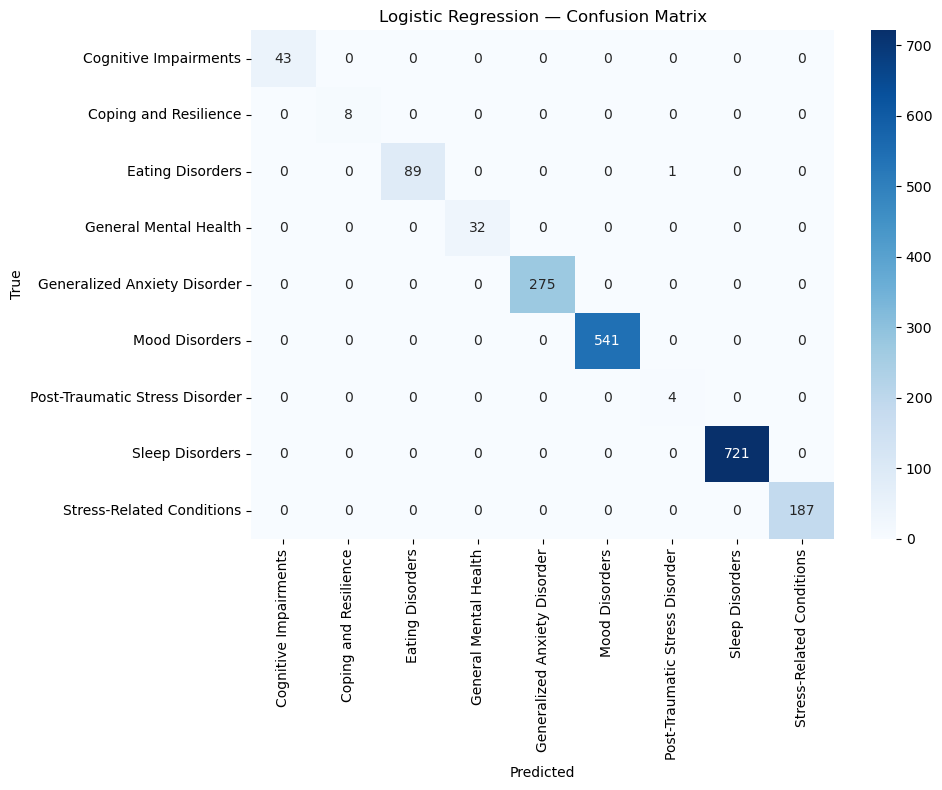

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=pipe.classes_,
    yticklabels=pipe.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression — Confusion Matrix")
plt.tight_layout()
plt.show()

In [15]:
pred_df = X_test.copy()
pred_df["true_label"] = y_test.values
pred_df["pred_label"] = y_pred

out_path = Path("../Outputs/Predictions/lr_predictions.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(out_path, index=False)

out_path

PosixPath('../Outputs/Predictions/lr_predictions.csv')

In [16]:
model_path = Path("../models/logistic_regression_pipeline.joblib")
model_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(pipe, model_path)

model_path

PosixPath('../models/logistic_regression_pipeline.joblib')